In [130]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam, Adamax

from keras import metrics
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from qiskit.quantum_info import SparsePauliOp
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
import seaborn as sns

import medmnist
from medmnist import INFO, Evaluator

# Load Data set

In [131]:
data_flag = 'dermamnist' # 'pneumoniamnist' 'pathmnist', 'retinamnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist,info['python_class'])

print('The number of classe are: ', n_classes,'\nAnd the number of channels: ', n_channels, '\nAnd the task is: ',task)

The number of classe are:  7 
And the number of channels:  3 
And the task is:  multi-class


In [132]:
# load the data
train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', download=True)
val_dataset = DataClass(split='val', download=True)

# number of instances
n_train = train_dataset.imgs.shape[0]
n_test = test_dataset.imgs.shape[0]
n_val = val_dataset.imgs.shape[0]

# Reshape the images
train_imgs_tf = np.reshape(train_dataset.imgs, (n_train,28,28,3))
test_imgs_tf = np.reshape(test_dataset.imgs, (n_test,28,28,3))
val_imgs_tf = np.reshape(val_dataset.imgs, (n_val,28,28,3))

# Load the labels
train_labels_tf = np.reshape(train_dataset.labels, (n_train,))
test_labels_tf = np.reshape(test_dataset.labels, (n_test,))
val_labels_tf = np.reshape(val_dataset.labels, (n_val,))

# Reduce dataset size
train_imgs_tf = train_imgs_tf[:n_train]
train_labels_tf = train_labels_tf[:n_train]
test_imgs_tf = test_imgs_tf[:n_test]
test_labels_tf = test_labels_tf[:n_test]
val_imgs_tf = val_imgs_tf[:n_val]
val_labels_tf = val_labels_tf[:n_val]

# Normalize pixel values within 0 and 1
train_imgs_tf = (train_imgs_tf / 255)*np.pi
test_imgs_tf = (test_imgs_tf / 255)*np.pi
val_imgs_tf = (val_imgs_tf / 255)*np.pi

Using downloaded and verified file: /home/carfloga/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/carfloga/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/carfloga/.medmnist/dermamnist.npz


## Let's see a little bit more in depth the data set

In [133]:
def plot_class_distribution(labels, dataset_name):
    unique_classes, counts = np.unique(labels, return_counts=True)
    plt.bar(unique_classes, counts)
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def print_class_distribution(labels, dataset_name):
    unique_classes, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    class_percentages = counts / total_samples * 100

    print(f'Class Distribution in {dataset_name} Set:')
    for cls, percentage in zip(unique_classes, class_percentages):
        print(f'Class {cls}: {percentage:.2f}%')


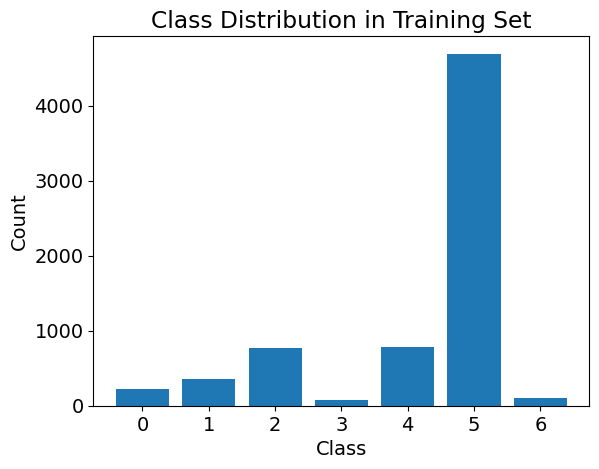

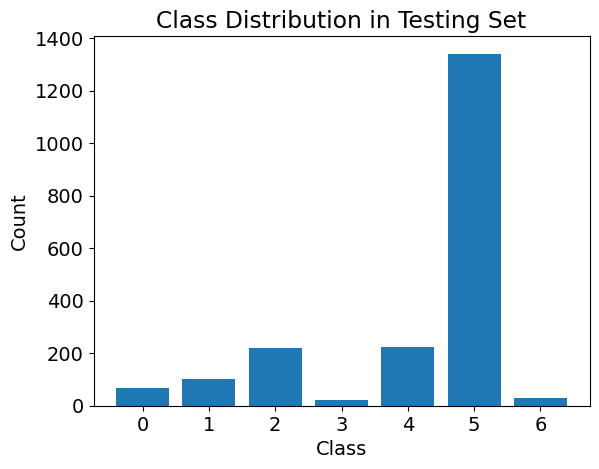

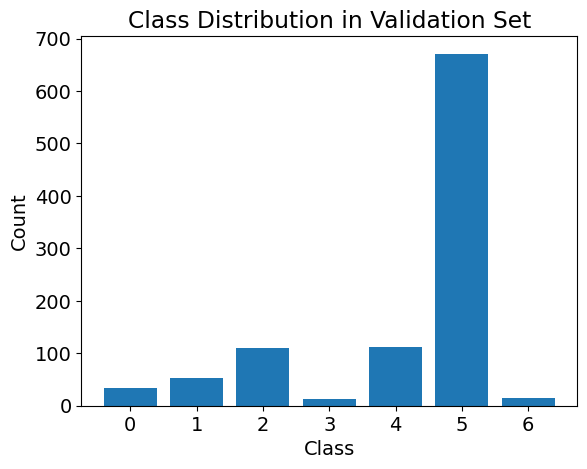

Class Distribution in Training Set:
Class 0: 3.25%
Class 1: 5.12%
Class 2: 10.97%
Class 3: 1.14%
Class 4: 11.12%
Class 5: 66.98%
Class 6: 1.41%
Class Distribution in Testing Set:
Class 0: 3.29%
Class 1: 5.14%
Class 2: 10.97%
Class 3: 1.15%
Class 4: 11.12%
Class 5: 66.88%
Class 6: 1.45%
Class Distribution in Validation Set:
Class 0: 3.29%
Class 1: 5.18%
Class 2: 10.97%
Class 3: 1.20%
Class 4: 11.07%
Class 5: 66.90%
Class 6: 1.40%


In [134]:
plot_class_distribution(train_labels_tf, 'Training')
plot_class_distribution(test_labels_tf, 'Testing')
plot_class_distribution(val_labels_tf, 'Validation')
print_class_distribution(train_labels_tf, 'Training')
print_class_distribution(test_labels_tf, 'Testing')
print_class_distribution(val_labels_tf, 'Validation')

# Different Quantum circuits Entangling

In [135]:
n_qubits = 9

graphs = {
   
    "king" : [[0,1],[0,3],[0,4],[1,2],[1,3],[1,4],[1,5],[2,3],[2,4],[3,4],[3,6],[3,7],[4,5],[4,6],[4,7],[4,8],[5,7],[5,8],[6,7],[7,8]],
    "serial" : [[0,1],[1,2],[2,5],[5,4],[4,3],[3,6],[6,7],[7,8]],
    "open-nn": [[0,1],[0,3],[1,2],[1,4],[2,5],[4,5],[4,7],[5,8],[3,6],[3,4],[6,7],[7,8]],
    "gamma": [[0,1],[0,3],[1,2],[1,4],[1,3],[1,5],[2,5],[4,5],[4,7],[5,7],[5,8],[3,6],[3,4],[6,7],[7,3],[7,8]]
}

## Let's define the 4 possible circuits

In [136]:
n_qubits = 9
dev = qml.device('default.qubit', wires=n_qubits)

## KING

In [137]:
@qml.qnode(dev, interface="autograd")
def king_circuit(params):
    """creates a quantum kernel based on a digital-analog quantum encoding.

    Args:
        params (torch.Parameters): trainable parameters

    Returns:
        list: expectation values of <Z> on each qubit
    """
    
    # DIGITAL ENCODING OF THE PIXELS
    for idx in range(n_qubits):
        qml.RY(params[idx], wires=idx)
        qml.Hadamard(wires=idx)
        
    # RYDBERG HAMILTONIAN EVOLUTION
    for t in [0.05, 0.1]:
        for qubit in range(n_qubits):
            qml.RX(t, wires=qubit)
            qml.RZ(t/2, wires=qubit)
        for pair in graphs["king"]:
            qml.CNOT(wires=[pair[0], pair[1]])
            qml.RZ(phi=np.pi/3, wires=pair[1])
            qml.CNOT(wires=[pair[0], pair[1]])
    
    # DIGITAL SINGLE-QUBIT OPERATIONS
    for qubit in range(n_qubits):
        qml.RY(np.pi/2, wires=qubit) 
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [138]:
# Initialize random parameters
params = np.random.rand(n_qubits)

# Draw the circuit
print(qml.draw(king_circuit)(params))

0: ──RY(0.45)──H──RX(0.05)──RZ(0.03)─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●──RX(0.10)
1: ──RY(0.13)──H──RX(0.05)──RZ(0.03)─╰X──RZ(1.05)─╰X─│────────────│──│────────────│──╭●───────
2: ──RY(0.88)──H──RX(0.05)──RZ(0.03)─────────────────│────────────│──│────────────│──╰X───────
3: ──RY(0.96)──H──RX(0.05)──RZ(0.03)─────────────────╰X──RZ(1.05)─╰X─│────────────│───────────
4: ──RY(0.42)──H──RX(0.05)──RZ(0.03)─────────────────────────────────╰X──RZ(1.05)─╰X──────────
5: ──RY(0.76)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
6: ──RY(0.38)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
7: ──RY(0.25)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
8: ──RY(0.49)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────

───RZ(0.05)────────────────────────────────────────────────────────────────────────╭●──────────
────────────╭●─╭●───────────╭●─╭●───────────╭●─╭

## Serial

In [139]:
@qml.qnode(dev, interface="autograd")
def serial_circuit(params):
    """creates a quantum kernel based on a digital-analog quantum encoding.

    Args:
        params (torch.Parameters): trainable parameters

    Returns:
        list: expectation values of <Z> on each qubit
    """
    
    # DIGITAL ENCODING OF THE PIXELS
    for idx in range(n_qubits):
        qml.RY(params[idx], wires=idx)
        qml.Hadamard(wires=idx)
        
    # RYDBERG HAMILTONIAN EVOLUTION
    for t in [0.05, 0.1]:
        for qubit in range(n_qubits):
            qml.RX(t, wires=qubit)
            qml.RZ(t/2, wires=qubit)
        for pair in graphs["serial"]:
            qml.CNOT(wires=[pair[0], pair[1]])
            qml.RZ(phi=np.pi/3, wires=pair[1])
            qml.CNOT(wires=[pair[0], pair[1]])
    
    # DIGITAL SINGLE-QUBIT OPERATIONS
    for qubit in range(n_qubits):
        qml.RY(np.pi/2, wires=qubit) 
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [140]:
# Initialize random parameters
params = np.random.rand(n_qubits)

# Draw the circuit
print(qml.draw(serial_circuit)(params))

0: ──RY(0.88)──H──RX(0.05)──RZ(0.03)─╭●───────────╭●──RX(0.10)──RZ(0.05)────────────────────────╭●
1: ──RY(0.53)──H──RX(0.05)──RZ(0.03)─╰X──RZ(1.05)─╰X─╭●──────────────────╭●──RX(0.10)──RZ(0.05)─╰X
2: ──RY(0.16)──H──RX(0.05)──RZ(0.03)─────────────────╰X─────────RZ(1.05)─╰X─╭●──────────────────╭●
3: ──RY(0.42)──H──RX(0.05)──RZ(0.03)────────────────────────────────────────│───────────────────│─
4: ──RY(0.57)──H──RX(0.05)──RZ(0.03)────────────────────────────────────────│───────────────────│─
5: ──RY(0.95)──H──RX(0.05)──RZ(0.03)────────────────────────────────────────╰X─────────RZ(1.05)─╰X
6: ──RY(0.05)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────────
7: ──RY(0.90)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────────
8: ──RY(0.44)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────────

────────────╭●─────────RY(1.57)─────────────────────────────────────────────────────────────────────
───RZ(1

## Opened

In [141]:
@qml.qnode(dev, interface="autograd")
def open_circuit(params):

    """creates a quantum kernel based on a digital-analog quantum encoding.

    Args:
        params (torch.Parameters): trainable parameters

    Returns:
        list: expectation values of <Z> on each qubit
    """
    
    # DIGITAL ENCODING OF THE PIXELS
    for idx in range(n_qubits):
        qml.RY(params[idx], wires=idx)
        qml.Hadamard(wires=idx)
        
    # RYDBERG HAMILTONIAN EVOLUTION
    for t in [0.05, 0.1]:
        for qubit in range(n_qubits):
            qml.RX(t, wires=qubit)
            qml.RZ(t/2, wires=qubit)
        for pair in graphs["open-nn"]:
            qml.CNOT(wires=[pair[0], pair[1]])
            qml.RZ(phi=np.pi/3, wires=pair[1])
            qml.CNOT(wires=[pair[0], pair[1]])
    
    # DIGITAL SINGLE-QUBIT OPERATIONS
    for qubit in range(n_qubits):
        qml.RY(np.pi/2, wires=qubit) 
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [142]:
# Initialize random parameters
params = np.random.rand(n_qubits)

# Draw the circuit
print(qml.draw(open_circuit)(params))

0: ──RY(0.59)──H──RX(0.05)──RZ(0.03)─╭●───────────╭●─╭●───────────╭●──RX(0.10)──RZ(0.05)──────
1: ──RY(0.92)──H──RX(0.05)──RZ(0.03)─╰X──RZ(1.05)─╰X─│────────────│──╭●──────────────────╭●─╭●
2: ──RY(0.45)──H──RX(0.05)──RZ(0.03)─────────────────│────────────│──╰X─────────RZ(1.05)─╰X─│─
3: ──RY(0.79)──H──RX(0.05)──RZ(0.03)─────────────────╰X──RZ(1.05)─╰X────────────────────────│─
4: ──RY(0.60)──H──RX(0.05)──RZ(0.03)────────────────────────────────────────────────────────╰X
5: ──RY(0.12)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
6: ──RY(0.95)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
7: ──RY(0.01)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
8: ──RY(0.56)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────

───────────────────────────────────╭●───────────╭●─────────────────────────────────────────────
────────────╭●──RX(0.10)──RZ(0.05)─╰X──RZ(1.05)─

## Gamma

In [143]:
@qml.qnode(dev, interface="autograd")
def gamma_circuit(params):
    """creates a quantum kernel based on a digital-analog quantum encoding.

    Args:
        params (torch.Parameters): trainable parameters

    Returns:
        list: expectation values of <Z> on each qubit
    """
    
    # DIGITAL ENCODING OF THE PIXELS
    for idx in range(n_qubits):
        qml.RY(params[idx], wires=idx)
        qml.Hadamard(wires=idx)
        
    # RYDBERG HAMILTONIAN EVOLUTION
    for t in [0.05, 0.1]:
        for qubit in range(n_qubits):
            qml.RX(t, wires=qubit)
            qml.RZ(t/2, wires=qubit)
        for pair in graphs["gamma"]:
            qml.CNOT(wires=[pair[0], pair[1]])
            qml.RZ(phi=np.pi/3, wires=pair[1])
            qml.CNOT(wires=[pair[0], pair[1]])
    
    # DIGITAL SINGLE-QUBIT OPERATIONS
    for qubit in range(n_qubits):
        qml.RY(np.pi/2, wires=qubit) 
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [144]:
# Initialize random parameters
params = np.random.rand(n_qubits)

# Draw the circuit
print(qml.draw(gamma_circuit)(params))

0: ──RY(0.40)──H──RX(0.05)──RZ(0.03)─╭●───────────╭●─╭●───────────╭●──RX(0.10)──RZ(0.05)──────
1: ──RY(0.56)──H──RX(0.05)──RZ(0.03)─╰X──RZ(1.05)─╰X─│────────────│──╭●──────────────────╭●─╭●
2: ──RY(0.96)──H──RX(0.05)──RZ(0.03)─────────────────│────────────│──╰X─────────RZ(1.05)─╰X─│─
3: ──RY(0.88)──H──RX(0.05)──RZ(0.03)─────────────────╰X──RZ(1.05)─╰X────────────────────────│─
4: ──RY(0.69)──H──RX(0.05)──RZ(0.03)────────────────────────────────────────────────────────╰X
5: ──RY(0.70)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
6: ──RY(0.22)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
7: ──RY(0.57)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────
8: ──RY(0.05)──H──RX(0.05)──RZ(0.03)──────────────────────────────────────────────────────────

───────────────────────────────────────────────────────────────────╭●───────────╭●─────────────
────────────╭●─╭●───────────╭●─╭●───────────╭●──

# Let's define the quanvolution

In [145]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((26, 26, 27))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 26, 1):
        for k in range(0, 26, 1):
            # Process a squared 2x2 region of the image with a quantum circuit
            q1_results = king_circuit( # circuit 1
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j, k + 2, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0],
                    image[j + 1, k + 2, 0],
                    image[j + 2, k, 0],
                    image[j + 2, k + 1, 0],
                    image[j + 2, k + 2, 0],
                ]
            )
            
            q2_results = king_circuit( # circuit 2
                [
                    image[j, k, 1],
                    image[j, k + 1, 1],
                    image[j, k + 2, 1],
                    image[j + 1, k, 1],
                    image[j + 1, k + 1, 1],
                    image[j + 1, k + 2, 1],
                    image[j + 2, k, 1],
                    image[j + 2, k + 1, 1],
                    image[j + 2, k + 2, 1],
                ]
            )
            q3_results = king_circuit( # circuit 3
                [
                    image[j, k, 2],
                    image[j, k + 1, 2],
                    image[j, k + 2, 2],
                    image[j + 1, k, 2],
                    image[j + 1, k + 1, 2],
                    image[j + 1, k + 2, 2],
                    image[j + 2, k, 2],
                    image[j + 2, k + 1, 2],
                    image[j + 2, k + 2, 2],
                ]
            )
            #print(len(q1_results))
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(9): 
                out[j, k, c] = q1_results[c]
            for c in range(9):
                out[j, k, c+9] = q2_results[c]
            for c in range(9): 
                out[j, k, c+18] = q3_results[c]
    return out

In [17]:
PREPROCESS = True

In [ ]:
SAVE_PATH = "kernel_3x3_king_all_qubits/"
if PREPROCESS == True: 
    # PROCCESS TRAIN DATA SET
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_imgs_tf):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)
    
    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    
    # PROCCESS TEST DATA SET
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_imgs_tf):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)
    
    # Save pre-processed images
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)
    
    
    # PROCCESS VALIDATION DATA SET
    q_val_images = []
    print("\nQuantum pre-processing of val images:")
    for idx, img in enumerate(val_imgs_tf):
        print("{}/{}        ".format(idx + 1, n_val), end="\r")
        q_val_images.append(quanv(img))
    q_val_images = np.asarray(q_val_images)
    
    # Save pre-processed images
    np.save(SAVE_PATH + "q_val_images.npy", q_val_images)
    

Quantum pre-processing of train images:


In [ ]:
# Save pre-processed images
np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
np.save(SAVE_PATH + "q_test_images.npy", q_test_images)
np.save(SAVE_PATH + "q_val_images.npy", q_val_images)

In [146]:
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
q_val_images = np.load(SAVE_PATH + "q_val_images.npy")

# Let's see the ressultant images

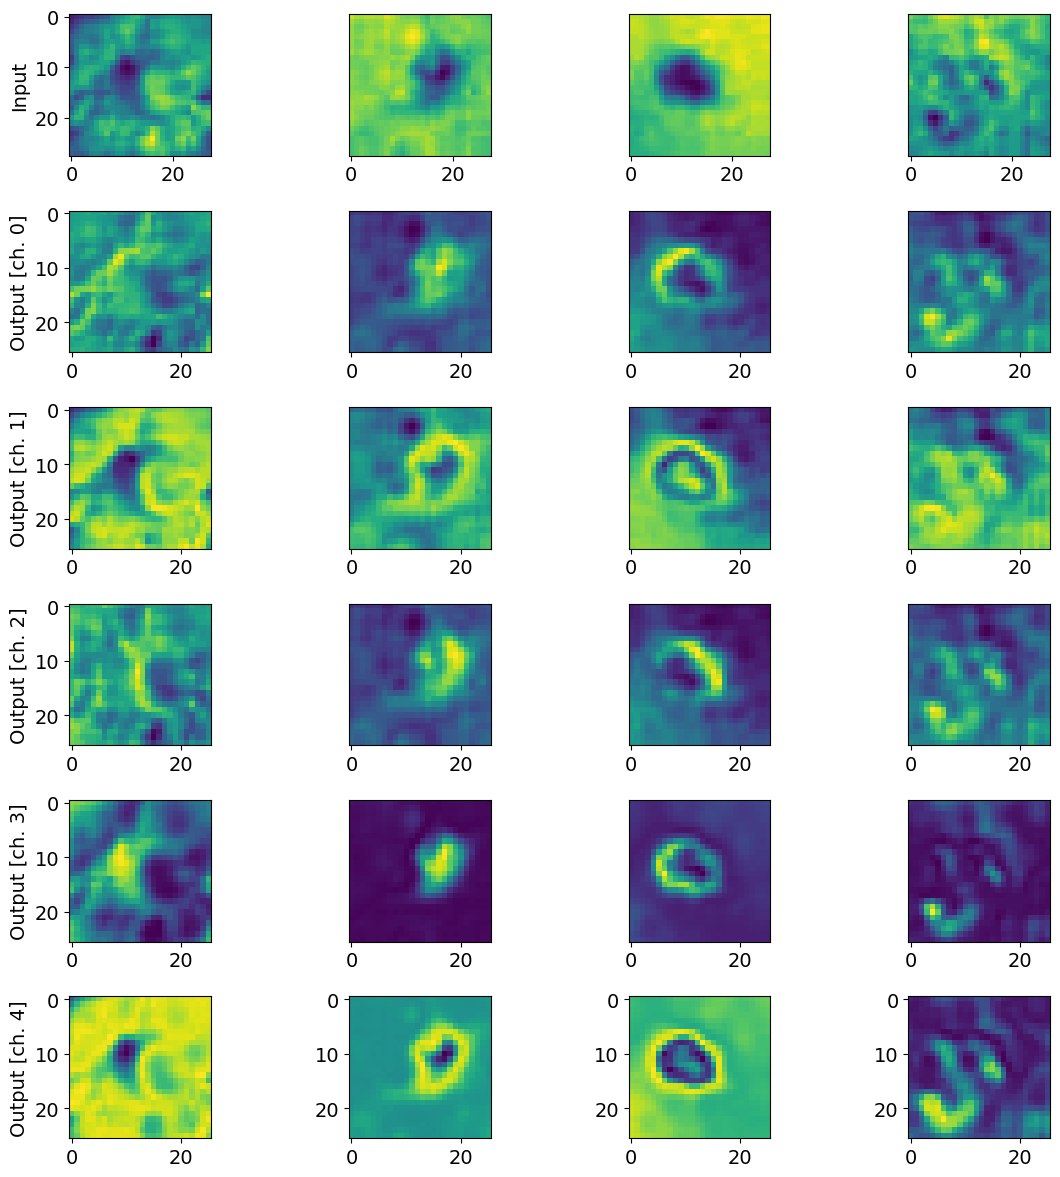

In [147]:
# PRINT SOME SAMPLES
n_samples = 4
n_channels = 5
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(12, 12))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_imgs_tf[k, :, :, 0])

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c])

plt.tight_layout()
plt.show()

# Creating the different models

In [148]:

def CNN(learning_rate=0.0005):
    """Initializes and returns a custom Keras model for 7 classes."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(18, (2, 2), strides=1, activation='relu', input_shape=(28, 28, 3)),
        keras.layers.BatchNormalization(momentum=0.98),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(14, (2, 2), strides=1, activation='relu'),
        keras.layers.BatchNormalization(momentum=0.98),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(7, activation="softmax")  # Cambiamos a 7 neuronas con softmax
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, decay=1e-06),
        loss="sparse_categorical_crossentropy",  # Cambiamos a sparse_categorical_crossentropy
        metrics=["sparse_categorical_accuracy"],  # Cambiamos a sparse_categorical_accuracy
    )
    return model


def qcnn(learning_rate=0.0005):
    """Initializes and returns a custom Keras model for 7 classes."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(36, (2, 2), strides=1, activation='gelu', input_shape=(26, 26, 27), trainable=True),
        keras.layers.BatchNormalization(momentum=0.96),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(18, (2, 2), strides=1, activation='gelu', trainable=True),
        keras.layers.Dropout(0.55),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.55),
        keras.layers.Dense(7, activation="softmax")  # Cambiamos a 7 neuronas con softmax
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, decay=1e-06),
        loss="sparse_categorical_crossentropy",  # Cambiamos a sparse_categorical_crossentropy
        metrics=["sparse_categorical_accuracy"],  # Cambiamos a sparse_categorical_accuracy
    )
    return model

In [149]:
q_model = qcnn(0.0005)

q_history = q_model.fit(
    q_train_images,
    train_labels_tf,
    validation_data=(q_val_images, val_labels_tf),
    batch_size=32,
    epochs=100,
    verbose=2
)

Epoch 1/100
219/219 - 6s - loss: 1.2704 - sparse_categorical_accuracy: 0.5934 - val_loss: 0.8436 - val_sparse_categorical_accuracy: 0.7009 - 6s/epoch - 26ms/step
Epoch 2/100
219/219 - 3s - loss: 0.9431 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.8368 - val_sparse_categorical_accuracy: 0.6969 - 3s/epoch - 14ms/step
Epoch 3/100
219/219 - 3s - loss: 0.8816 - sparse_categorical_accuracy: 0.6856 - val_loss: 0.7730 - val_sparse_categorical_accuracy: 0.7159 - 3s/epoch - 14ms/step
Epoch 4/100
219/219 - 3s - loss: 0.8485 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.7328 - 3s/epoch - 13ms/step
Epoch 5/100
219/219 - 3s - loss: 0.8193 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.7878 - val_sparse_categorical_accuracy: 0.7188 - 3s/epoch - 15ms/step
Epoch 6/100
219/219 - 3s - loss: 0.8066 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.7473 - val_sparse_categorical_accuracy: 0.7218 - 3s/epoch - 14ms/step
Epoch 7/100
219/219 - 3s - l

Epoch 52/100
219/219 - 3s - loss: 0.6184 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.6800 - val_sparse_categorical_accuracy: 0.7587 - 3s/epoch - 14ms/step
Epoch 53/100
219/219 - 3s - loss: 0.6295 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.7248 - val_sparse_categorical_accuracy: 0.7458 - 3s/epoch - 14ms/step
Epoch 54/100
219/219 - 3s - loss: 0.6123 - sparse_categorical_accuracy: 0.7674 - val_loss: 0.7047 - val_sparse_categorical_accuracy: 0.7488 - 3s/epoch - 14ms/step
Epoch 55/100
219/219 - 3s - loss: 0.6221 - sparse_categorical_accuracy: 0.7697 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.7388 - 3s/epoch - 14ms/step
Epoch 56/100
219/219 - 3s - loss: 0.6142 - sparse_categorical_accuracy: 0.7699 - val_loss: 0.6990 - val_sparse_categorical_accuracy: 0.7458 - 3s/epoch - 13ms/step
Epoch 57/100
219/219 - 3s - loss: 0.6068 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.7016 - val_sparse_categorical_accuracy: 0.7488 - 3s/epoch - 13ms/step
Epoch 58/100
219/219 -

In [150]:
c_model = CNN(0.0005)

c_history = c_model.fit(
    train_imgs_tf,
    train_labels_tf,
    validation_data=(val_imgs_tf, val_labels_tf),
    batch_size=32,
    epochs=100,
    verbose=2,
)

Epoch 1/100
219/219 - 5s - loss: 1.3536 - sparse_categorical_accuracy: 0.5894 - val_loss: 1.0471 - val_sparse_categorical_accuracy: 0.6231 - 5s/epoch - 24ms/step
Epoch 2/100
219/219 - 5s - loss: 1.0250 - sparse_categorical_accuracy: 0.6588 - val_loss: 0.8477 - val_sparse_categorical_accuracy: 0.6939 - 5s/epoch - 22ms/step
Epoch 3/100
219/219 - 5s - loss: 0.9226 - sparse_categorical_accuracy: 0.6762 - val_loss: 0.8075 - val_sparse_categorical_accuracy: 0.7089 - 5s/epoch - 22ms/step
Epoch 4/100
219/219 - 5s - loss: 0.8545 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9242 - val_sparse_categorical_accuracy: 0.6909 - 5s/epoch - 23ms/step
Epoch 5/100
219/219 - 5s - loss: 0.8162 - sparse_categorical_accuracy: 0.7016 - val_loss: 0.7501 - val_sparse_categorical_accuracy: 0.7338 - 5s/epoch - 23ms/step
Epoch 6/100
219/219 - 5s - loss: 0.7882 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.8719 - val_sparse_categorical_accuracy: 0.7119 - 5s/epoch - 23ms/step
Epoch 7/100
219/219 - 4s - l

Epoch 52/100
219/219 - 5s - loss: 0.5300 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.9454 - val_sparse_categorical_accuracy: 0.6331 - 5s/epoch - 21ms/step
Epoch 53/100
219/219 - 4s - loss: 0.5261 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.8132 - val_sparse_categorical_accuracy: 0.7049 - 4s/epoch - 19ms/step
Epoch 54/100
219/219 - 4s - loss: 0.5162 - sparse_categorical_accuracy: 0.8001 - val_loss: 1.1841 - val_sparse_categorical_accuracy: 0.6899 - 4s/epoch - 19ms/step
Epoch 55/100
219/219 - 5s - loss: 0.5214 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.9008 - val_sparse_categorical_accuracy: 0.7069 - 5s/epoch - 22ms/step
Epoch 56/100
219/219 - 5s - loss: 0.5038 - sparse_categorical_accuracy: 0.8093 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.6471 - 5s/epoch - 22ms/step
Epoch 57/100
219/219 - 5s - loss: 0.5081 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.6690 - 5s/epoch - 23ms/step
Epoch 58/100
219/219 -

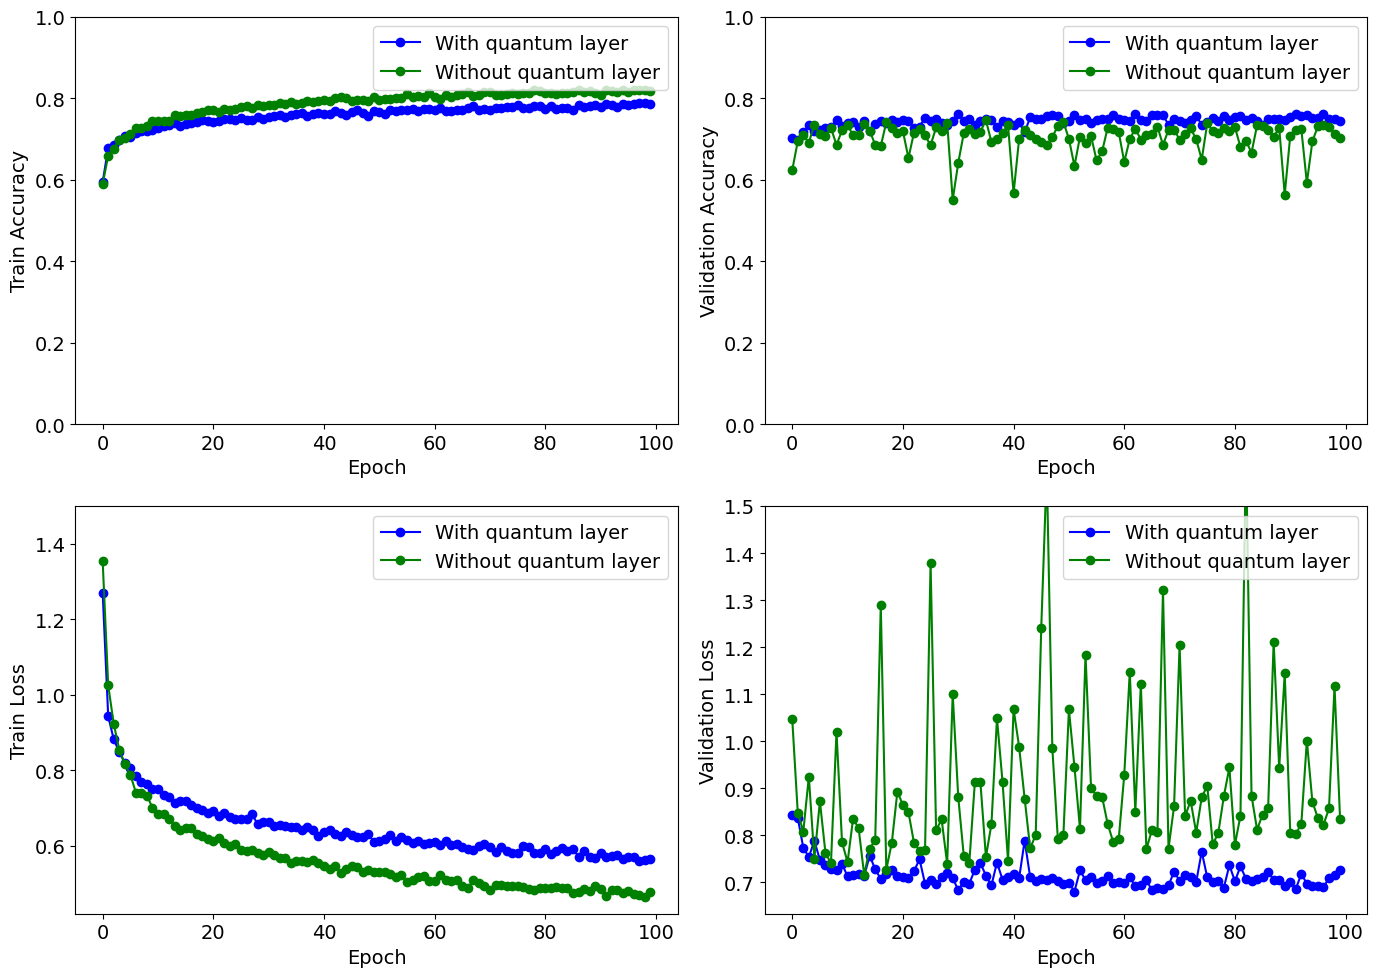

In [151]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 1].plot(q_history.history["val_sparse_categorical_accuracy"], "-ob", label="With quantum layer")
ax[0, 1].plot(c_history.history["val_sparse_categorical_accuracy"], "-og", label="Without quantum layer")
ax[0, 1].set_ylabel("Validation Accuracy")
ax[0, 1].set_ylim([0, 1],)
ax[0, 1].set_xlabel("Epoch")
ax[0, 1].legend()

ax[0, 0].plot(q_history.history["sparse_categorical_accuracy"], "-ob", label="With quantum layer")
ax[0, 0].plot(c_history.history["sparse_categorical_accuracy"], "-og", label="Without quantum layer")
ax[0, 0].set_ylabel("Train Accuracy")
ax[0, 0].set_ylim([0, 1],)
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].legend()

ax[1, 1].plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax[1, 1].plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax[1, 1].set_ylabel("Validation Loss")
ax[1, 1].set_ylim(top=1.5)
ax[1, 1].set_xlabel("Epoch")
ax[1, 1].legend()

ax[1, 0].plot(q_history.history["loss"], "-ob", label="With quantum layer")
ax[1, 0].plot(c_history.history["loss"], "-og", label="Without quantum layer")
ax[1, 0].set_ylabel("Train Loss")
ax[1, 0].set_ylim(top=1.5)
ax[1, 0].set_xlabel("Epoch")
ax[1, 0].legend()

plt.tight_layout()
plt.show()

In [152]:
q_predictions = q_model.predict(q_test_images) # qunatum pred
c_predictions = c_model.predict(test_imgs_tf) # classical pred

# Cambiar el formato de las predicciones a etiquetas con np.argmax para multiclasificación
q_pred_labels = np.argmax(q_predictions, axis=1)
c_pred_labels = np.argmax(c_predictions, axis=1)


print(f"\nQuantum results with {q_model.count_params()} params\n")
# Calcular el AUC (macro promedio para 7 clases)
auc_q = roc_auc_score(test_labels_tf, q_predictions, multi_class='ovr', average='macro')
print("AUC (Macro):", auc_q)

# Calcular F1 Score con promedio macro
f1_q = f1_score(test_labels_tf, q_pred_labels, average='macro')
print('F1 Score (Macro):', f1_q)

# Calcular precisión exacta
acc_q = accuracy_score(test_labels_tf, q_pred_labels)
print('Accuracy:', acc_q)

print(f"\nClassical results with {c_model.count_params()} params\n")
# Calcular el AUC (macro promedio para 7 clases)
auc_c = roc_auc_score(test_labels_tf, c_predictions, multi_class='ovr', average='macro')
print("AUC (Macro):", auc_c)

# Calcular F1 Score con promedio macro
f1_c = f1_score(test_labels_tf, c_pred_labels, average='macro')
print('F1 Score (Macro):', f1_c)

# Calcular precisión exacta
acc_c = accuracy_score(test_labels_tf, c_pred_labels)
print('Accuracy:', acc_c)

63/63 [==============================] - 0s 4ms/step

Quantum results with 21931 params

AUC (Macro): 0.9183588593377346
F1 Score (Macro): 0.4814324540816902
Accuracy: 0.7391521197007481

Classical results with 15503 params

AUC (Macro): 0.8919867112499255
F1 Score (Macro): 0.42348030890341787
Accuracy: 0.7072319201995012


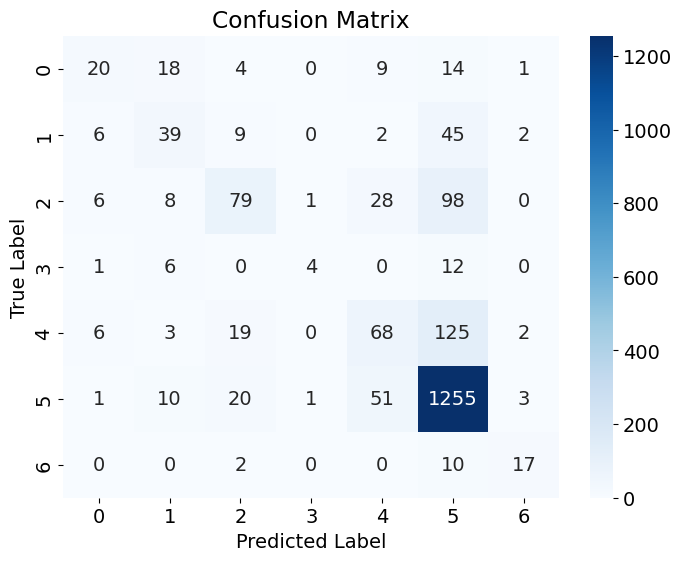

In [153]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(test_labels_tf, q_pred_labels)

# Configura el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Let's train the same model 100 times and save results each time

In [78]:
def AUC_and_ACC(data = test_labels_tf, pred = q_predictions):
    auc = roc_auc_score(data, pred, multi_class='ovr', average='macro')
    pred_acc = np.argmax(pred, axis=1)
    acc = accuracy_score(data, pred_acc)
    return auc, acc

In [79]:
learning_rate = 0.0005
batch_size = 32
dropout = 0.55

In [ ]:
train_ACC = []
train_AUC = []

test_ACC = []
test_AUC = []

val_ACC = []
val_AUC = []

model_weights = []  # save weights

for i in range(100):
    model = qcnn(learning_rate=learning_rate)
    
    history = model.fit(
        q_train_images,
        train_labels_tf,
        validation_data=(q_val_images, val_labels_tf),
        batch_size=batch_size,
        epochs=100,
        verbose=100,
    )
    
    # Guardar los pesos del modelo
    model_weights.append(model.get_weights())
    
    q_predictions_train = model.predict(q_train_images)
    auc_train, acc_train = AUC_and_ACC(data=train_labels_tf, pred=q_predictions_train)
    train_AUC.append(auc_train)
    train_ACC.append(acc_train)
    
    q_predictions_test = model.predict(q_test_images)
    auc_test, acc_test = AUC_and_ACC(data=test_labels_tf, pred=q_predictions_test)
    test_AUC.append(auc_test)
    test_ACC.append(acc_test)
    
    q_predictions_val = model.predict(q_val_images)
    auc_val, acc_val = AUC_and_ACC(data=val_labels_tf, pred=q_predictions_val)
    val_AUC.append(auc_val)
    val_ACC.append(acc_val)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79/100
Epoch 80/100
Epoch 81/100
Epoch 82/100
Epoch 83/100
Epoch 84/100
Epoch 85/100
Epoch 86/100
Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
32/32 [==============================] - 0s 2ms/step
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 

Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79/100
Epoch 80/100
Epoch 81/100
Epoch 82/100
Epoch 83/100
Epoch 84/100
Epoch 85/100
Epoch 86/100
Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
32/32 [==============================] - 0s 2ms/step
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epo

Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79/100
Epoch 80/100
Epoch 81/100
Epoch 82/100
Epoch 83/100
Epoch 84/100
Epoch 85/100
Epoch 86/100
Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
32/32 [==============================] - 0s 3ms/step
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 

Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79/100
Epoch 80/100
Epoch 81/100
Epoch 82/100
Epoch 83/100
Epoch 84/100
Epoch 85/100
Epoch 86/100
Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
32/32 [====

Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
32/32 [==============================] - 0s 3ms/step
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 

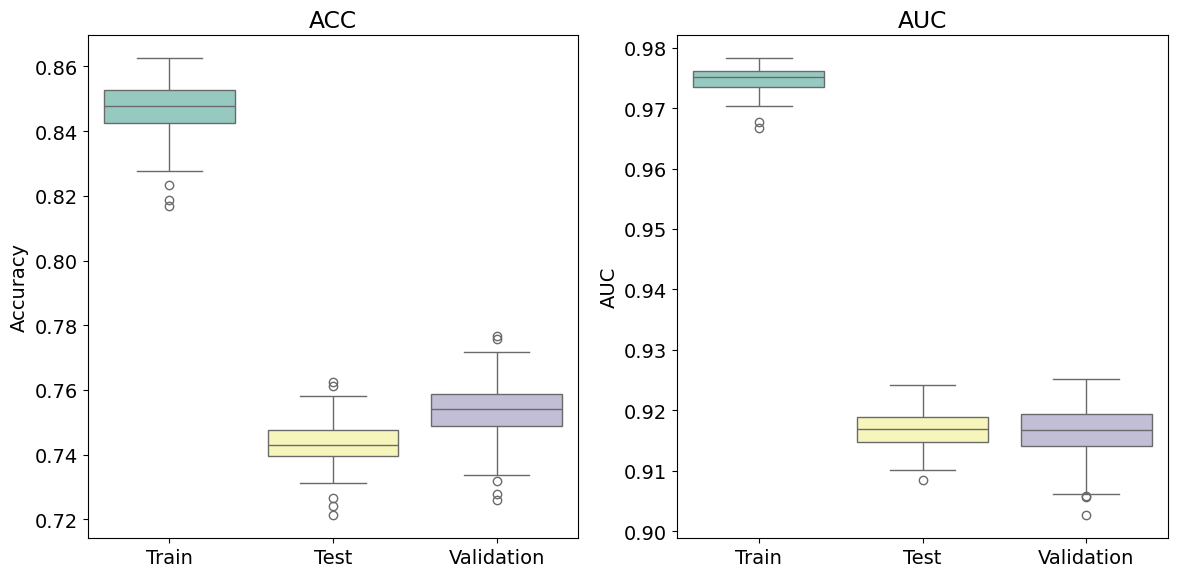

In [81]:
# Crear los box plots
plt.figure(figsize=(12, 6))

# Box plot para ACC
plt.subplot(1, 2, 1)
sns.boxplot(data=[train_ACC, test_ACC, val_ACC], palette="Set3")
plt.title('ACC')
plt.xticks([0, 1, 2], ['Train', 'Test', 'Validation'])
plt.ylabel('Accuracy')

# Box plot para AUC
plt.subplot(1, 2, 2)
sns.boxplot(data=[train_AUC, test_AUC, val_AUC], palette="Set3")
plt.title('AUC')
plt.xticks([0, 1, 2], ['Train', 'Test', 'Validation'])
plt.ylabel('AUC')

# Ajustes estéticos adicionales
plt.tight_layout()

# Mostrar los box plots
plt.show()

In [82]:
print('The median of the AUC: \nTrain: ',np.median(train_AUC), '\nTest: ',np.median(test_AUC), '\nValidation: ',np.median(val_AUC))
print('The median of the ACC: \nTrain: ',np.median(train_ACC), '\nTest: ',np.median(test_ACC), '\nValidation: ',np.median(val_ACC))

The median of the AUC: 
Train:  0.975194251339294 
Test:  0.9169686637167671 
Validation:  0.9167472852824827
The median of the ACC: 
Train:  0.8478664192949907 
Test:  0.7428927680798005 
Validation:  0.7542372881355932


### Best attempt:

In [106]:
best_model_index = np.argmax(test_AUC) # save index
best_model_weights = model_weights[best_model_index] # best weights

# set weights on the model
best_model = qcnn(learning_rate=learning_rate)
best_model.set_weights(best_model_weights)

In [107]:
# predictions
best_pred = best_model.predict(q_test_images)

63/63 [==============================] - 0s 3ms/step


In [108]:
q_best_pred = np.argmax(best_pred, axis=1)

In [110]:
# AUC:
auc = roc_auc_score(test_labels_tf, best_pred, multi_class='ovr', average='macro')
 
print("AUC:", auc)

# F1_score and recall:
f1 = f1_score(test_labels_tf, q_best_pred, average='macro')

#print('F1_Score:', f1)

# ACCURACY:
acc = accuracy_score(test_labels_tf, q_best_pred)
print('ACC:', acc)

AUC: 0.9242550760548818
ACC: 0.7581047381546134


# Classical model:


In [111]:
learning_rate = 0.0005
batch_size = 32
dropout = 0.55

In [ ]:
c_train_ACC = []
c_train_AUC = []

c_test_ACC = []
c_test_AUC = []

c_val_ACC = []
c_val_AUC = []

c_model_weights = []  # save weights

for i in range(200):
    model = CNN(learning_rate=learning_rate)
    
    history = model.fit(
        train_imgs_tf,
        train_labels_tf,
        validation_data=(val_imgs_tf, val_labels_tf),
        batch_size=batch_size,
        epochs=100,
        verbose=100,
    )
    
    # Guardar los pesos del modelo
    c_model_weights.append(model.get_weights())
    
    predictions_train = model.predict(train_imgs_tf)
    auc_train, acc_train = AUC_and_ACC(data=train_labels_tf, pred=predictions_train)
    c_train_AUC.append(auc_train)
    c_train_ACC.append(acc_train)
    
    predictions_test = model.predict(test_imgs_tf)
    auc_test, acc_test = AUC_and_ACC(data=test_labels_tf, pred=predictions_test)
    c_test_AUC.append(auc_test)
    c_test_ACC.append(acc_test)
    
    predictions_val = model.predict(val_imgs_tf)
    auc_val, acc_val = AUC_and_ACC(data=val_labels_tf, pred=predictions_val)
    c_val_AUC.append(auc_val)
    c_val_ACC.append(acc_val)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

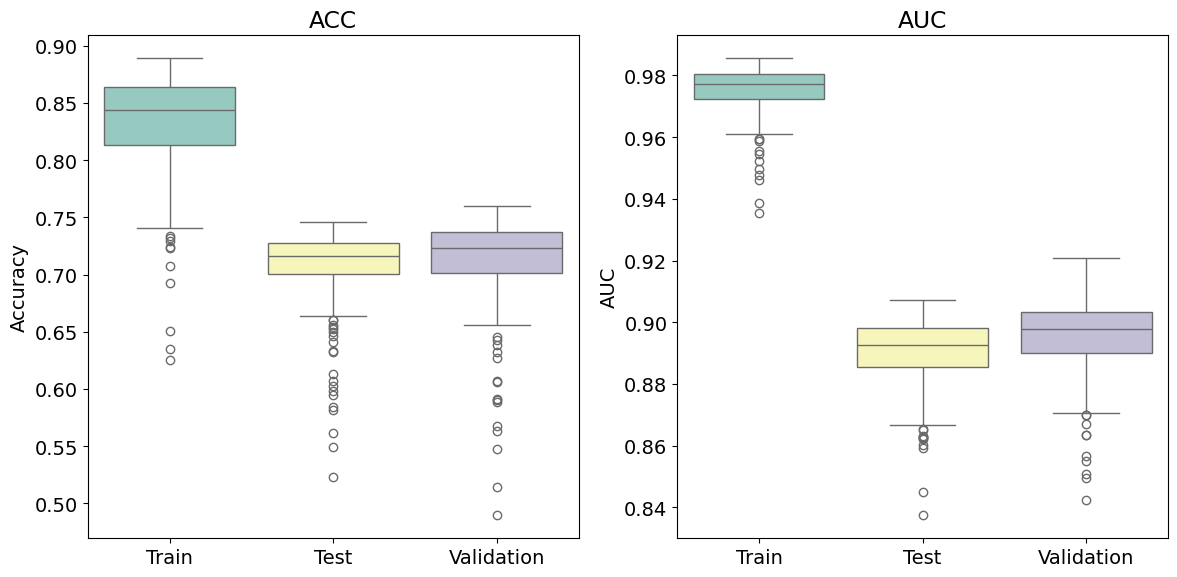

In [113]:
# Crear los box plots
plt.figure(figsize=(12, 6))

# Box plot para ACC
plt.subplot(1, 2, 1)
sns.boxplot(data=[c_train_ACC, c_test_ACC, c_val_ACC], palette="Set3")
plt.title('ACC')
plt.xticks([0, 1, 2], ['Train', 'Test', 'Validation'])
plt.ylabel('Accuracy')

# Box plot para AUC
plt.subplot(1, 2, 2)
sns.boxplot(data=[c_train_AUC, c_test_AUC, c_val_AUC], palette="Set3")
plt.title('AUC')
plt.xticks([0, 1, 2], ['Train', 'Test', 'Validation'])
plt.ylabel('AUC')

# Ajustes estéticos adicionales
plt.tight_layout()

# Mostrar los box plots
plt.show()

In [114]:
print('The median of the AUC: \nTrain: ',np.median(c_train_AUC), '\nTest: ',np.median(c_test_AUC), '\nValidation: ',np.median(c_val_AUC))
print('The median of the ACC: \nTrain: ',np.median(c_train_ACC), '\nTest: ',np.median(c_test_ACC), '\nValidation: ',np.median(c_val_ACC))

The median of the AUC: 
Train:  0.9773203631982454 
Test:  0.8926889162594804 
Validation:  0.8977424750787448
The median of the ACC: 
Train:  0.843727700870558 
Test:  0.7164588528678304 
Validation:  0.7228315054835494


### Best attempt:

In [118]:
best_model_index = np.argmax(c_test_AUC) # save index
best_model_weights = c_model_weights[best_model_index] # best weights

# set weights on the model
best_model = CNN(learning_rate=learning_rate)
best_model.set_weights(best_model_weights)

In [121]:
# predictions
best_pred = best_model.predict(test_imgs_tf)

63/63 [==============================] - 0s 3ms/step


In [124]:
c_best_pred = np.argmax(best_pred, axis=1)

In [125]:
# AUC:
auc = roc_auc_score(test_labels_tf, best_pred, multi_class='ovr', average='macro')
 
print("AUC:", auc)

# F1_score and recall:
f1 = f1_score(test_labels_tf, c_best_pred, average='macro')

#print('F1_Score:', f1)

# ACCURACY:
acc = accuracy_score(test_labels_tf, c_best_pred)
print('ACC:', acc)

AUC: 0.9071416156931595
ACC: 0.7321695760598503


# Comparison Classical vs DA-QC

In [126]:
df_acc = pd.DataFrame()
# Crear DataFrame Accuracy
df_acc['Model'] = ['Classic']*len(c_test_ACC) + ['Quantum']*len(test_ACC)
df_acc['ACC'] = c_test_ACC + test_ACC

df_auc = pd.DataFrame()
# crear df AUC
df_auc['Model'] = ['Classic']*len(c_test_AUC) + ['Quantum']*len(test_AUC)
df_auc['AUC'] = c_test_AUC + test_AUC

/tmp/ipykernel_4665/950699990.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='ACC', data=df_acc, palette="colorblind", linewidth=1.2)
/tmp/ipykernel_4665/950699990.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='AUC', data=df_auc, palette="colorblind", linewidth=1.2)


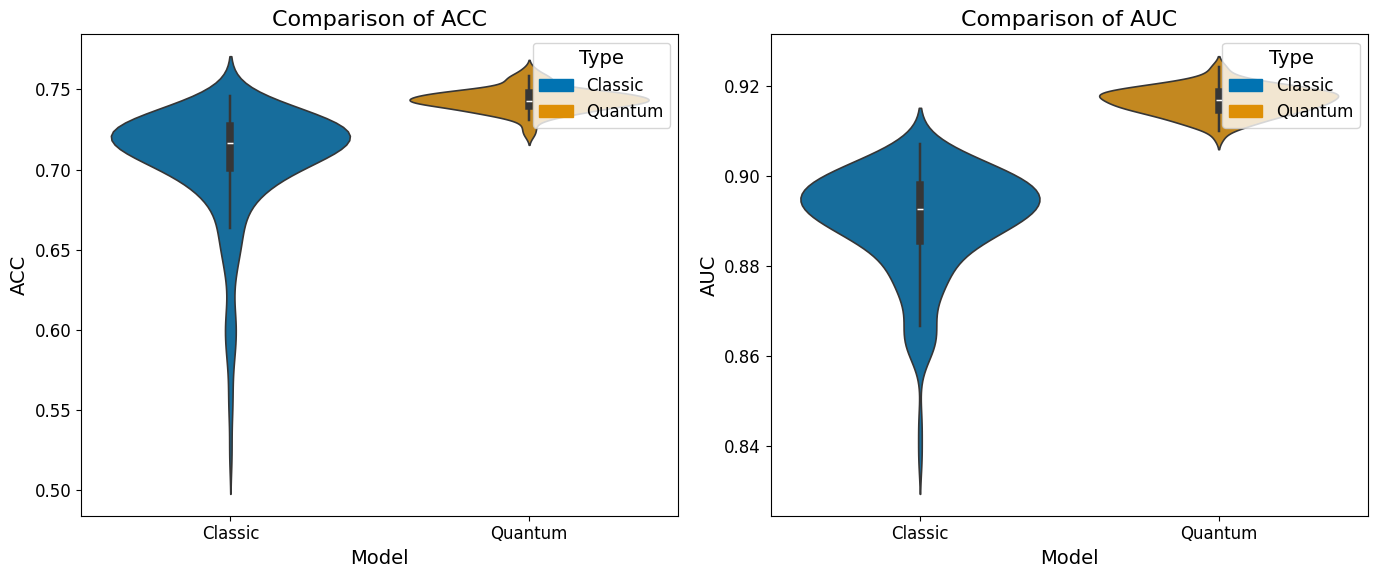

In [127]:
# Plot with Seaborn
plt.figure(figsize=(14, 6))

# ACC plot
plt.subplot(1, 2, 1)
sns.violinplot(x='Model', y='ACC', data=df_acc, palette="colorblind", linewidth=1.2)
plt.title('Comparison of ACC', fontsize=16)
plt.ylabel('ACC', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Custom legend for ACC
legend_patch = [mpatches.Patch(color=sns.color_palette("colorblind")[0], label='Classic'),
                mpatches.Patch(color=sns.color_palette("colorblind")[1], label='Quantum')]
plt.legend(handles=legend_patch, title='Type', fontsize=12)

# AUC plot
plt.subplot(1, 2, 2)
sns.violinplot(x='Model', y='AUC', data=df_auc, palette="colorblind", linewidth=1.2)
plt.title('Comparison of AUC', fontsize=16)
plt.ylabel('AUC', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Custom legend for AUC
plt.legend(handles=legend_patch, title='Type', fontsize=12)

plt.tight_layout()
plt.show()